## Regularización en Regresión Lineal

La **regularización** se utiliza para evitar el sobreajuste, añadiendo un término de penalización a la función de coste que disuade al modelo de tener coeficientes con valores absolutos grandes. La regularización usada es  **Regularización L2**, también conocida como *Ridge Regression*.

### Función de Coste con Regularización L2

La función de coste regularizada `calcularCosto` incluye un término adicional que penaliza la magnitud de los coeficientes (excepto el término de sesgo):

```python
def calcularCosto(X, y, theta, lambda_):
    m = y.size
    h = np.dot(X, theta)
    J = (1 / (2 * m)) * np.sum(np.square(h - y)) + (lambda_ / (2 * m)) * np.sum(np.square(theta[1:]))
    return J
```

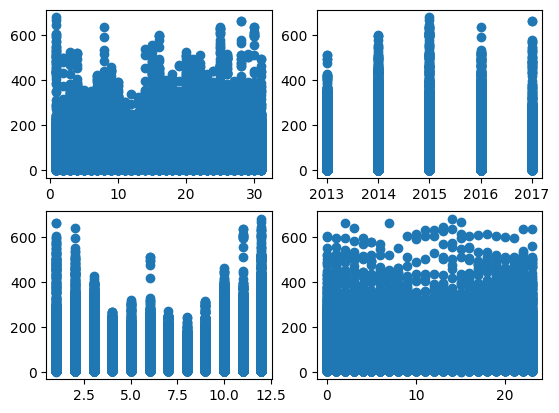

In [42]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as pyplot

# Cargar los datos
df = pd.read_csv('../Laboratorio1/PRSA_Data_Guanyuan_20130301-20170228.csv')

# Elimina filas donde y (PM2.5) tiene valores NaN
df = df.dropna(subset=['PM2.5'])



# Imputación de NaNs antes de la asignación de X y y
numeric_columns = df.select_dtypes(include=[np.number]).columns
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].median())

# Asignación de X y y después de la imputación
X = df[numeric_columns].drop('PM2.5', axis=1).values
y = df['PM2.5'].values
m = y.size

fig,axs = pyplot.subplots(2,2)
axs[0, 0].plot(X[:,3],y,'o')
axs[0, 1].plot(X[:,1],y,'o')
axs[1, 0].plot(X[:,2],y,'o')
axs[1, 1].plot(X[:,4],y,'o')

In [43]:
def featureNormalize(X):
    # Calcular la media y la desviación estándar
    mu = np.mean(X, axis=0)
    sigma = np.std(X, axis=0)

    
    # Normalizar las características
    X_norm = (X - mu) / sigma
    
    # Verificar si se ha introducido algún NaN durante la normalización
    if np.any(np.isnan(X_norm)):
        print("NaN encontrado en la normalización")
        print(X_norm)
        # Imprimir para depuración

    return X_norm, mu, sigma

features_columns = ['PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']
X = df[features_columns].values

X_norm, mu, sigma = featureNormalize(X)

print('Media calculada:', mu)
print('Desviación estandar calculada:', sigma)
print(X_norm)

Media calculada: [1.08897649e+02 1.75750839e+01 5.78432968e+01 1.25370085e+03
 5.53502027e+01 1.35039443e+01 1.01192594e+03 3.05964642e+00
 6.71562935e-02 1.70833720e+00]
Desviación estandar calculada: [9.08544385e+01 2.35611045e+01 3.48843214e+01 1.13400193e+03
 5.67040976e+01 1.13875697e+01 1.03715534e+01 1.36810584e+01
 9.11393802e-01 1.20300084e+00]
[[-1.15456823 -0.15173668 -1.0848225  ... -1.59780375 -0.07368526
   2.23745711]
 [-1.15456823 -0.19417952 -1.17082102 ... -1.55394749 -0.07368526
   2.4868335 ]
 [-1.16557485 -0.32150801 -1.11348867 ... -1.55394749 -0.07368526
   3.23496265]
 ...
 [-0.83537634 -0.53372217 -0.54016521 ... -1.19578807 -0.07368526
  -0.50568311]
 [-0.9344359  -0.53372217 -0.31083582 ... -1.16655056 -0.07368526
  -0.42255765]
 [-0.90141605 -0.53372217 -0.13883878 ... -1.38583184 -0.07368526
  -0.33943218]]


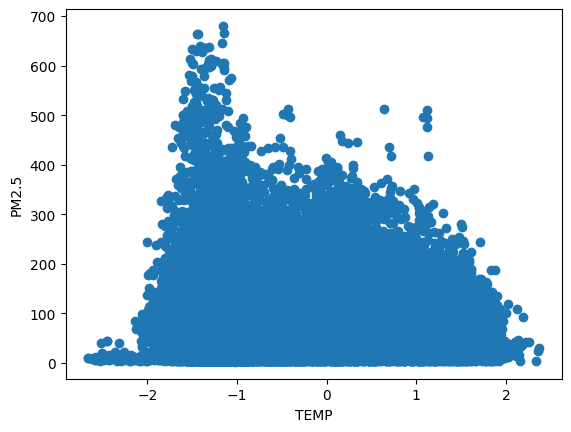

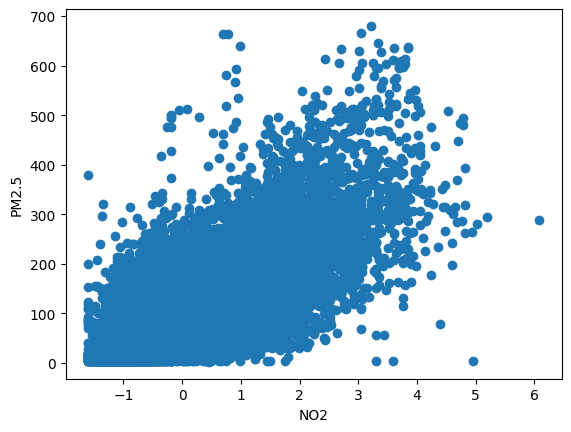

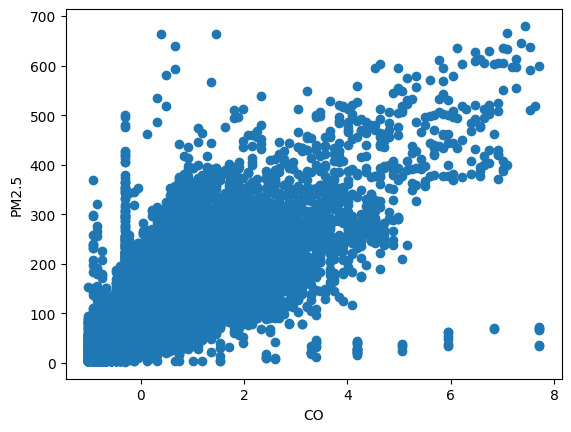

In [44]:
def graficarDatos(x, y, xlabel, ylabel):
    fig = pyplot.figure()
    pyplot.scatter(x, y)
    pyplot.xlabel(xlabel)
    pyplot.ylabel(ylabel)
    pyplot.show()


# Visualización de PM2.5 contra TEMP
graficarDatos(X_norm[:, 5], y, 'TEMP', 'PM2.5')  # TEMP

# Visualización de PM2.5 contra NO2
graficarDatos(X_norm[:, 2], y, 'NO2', 'PM2.5')  # NO2

# Visualización de PM2.5 contra CO
graficarDatos(X_norm[:, 3], y, 'CO', 'PM2.5')  # CO

In [45]:
# Agregar el término de intercepción

X_ready = np.concatenate([np.ones((m, 1)), X_norm], axis=1)

#### Regularización
Para realizar la regularización realicé cambios en la función. CalcularCosto y calcularDescensoGradiente

In [46]:
def calcularCosto(X, y, theta, lambda_):
    m = y.size
    J = 0
    h = np.dot(X, theta)
    J = (1 / (2 * m)) * np.sum(np.square(h - y)) + (lambda_ / (2 * m)) * np.sum(np.square(theta[1:]))
    return J

In [47]:
#Ajustar el tamaño de 'theta' para Coincidir con X_ready

# Inicializa theta con ceros para todas las características incluyendo el término de intercepción
theta = np.zeros(X_ready.shape[1])

# Costo con regularización, debes especificar un valor de lambda_ diferente de 0
lambda_reg = 1  # Ejemplo, debes ajustar este valor según lo que desees para tu regularización
JJ_reg = calcularCosto(X_ready, y, theta, lambda_=lambda_reg)
print(f"Con theta inicializado a ceros y con regularización (lambda={lambda_reg}), se obtiene un costo de: {JJ_reg}")


Con theta inicializado a ceros y con regularización (lambda=1), se obtiene un costo de: 6713.992518288434


### Descenso del Gradiente Regularizado
La implementación del descenso del gradiente calcularDescensoGradienteRegularizado actualiza los coeficientes tehta en cada iteración, aplicando la penalización solo a los coeficientes que no son el término de intercepción:

In [73]:
# Implementar el descenso por el Gradiente
def calcularDescensoGradienteRegularizado(X, y, theta, alpha, numero_iteraciones, lambda_):
    m = y.shape[0]
    theta = theta.copy()
    J_historico = []

    for i in range(numero_iteraciones):
        error = np.dot(X, theta) - y
        theta = theta * (1 - alpha * (lambda_ / m))  # Aplicar penalización excepto para theta[0]
        theta[0] = theta[0] - (alpha / m) * error.dot(X[:, 0])  # Actualización para theta[0] sin penalización
        for j in range(1, len(theta)):
            theta[j] = theta[j] - (alpha / m) * error.dot(X[:, j])  # Actualización con penalización
        J_historico.append(calcularCosto(X, y, theta, lambda_))  

    return theta, J_historico


In [49]:
alpha = 0.001 
num_ite = 35000  
lambda_reg = 1  

# Inicializa theta con ceros para todas las características incluyendo el término de intercepción
theta = np.zeros(X_ready.shape[1])

theta, J_historico = calcularDescensoGradienteRegularizado(X_ready, y, theta, alpha, num_ite, lambda_reg)

print(f"Los valores de theta calculados son: {theta}")
print(f"Con un costo de: {J_historico[-1]} ")

Los valores de theta calculados son: [ 82.93096461  51.78051257   2.16196582   5.81852559  19.96094107
   6.68120625 -11.77312935   6.14564873  19.15421948   0.18685504
  -0.33196851]
Con un costo de: 439.79997734381527 


Text(0, 0.5, 'Costo J')

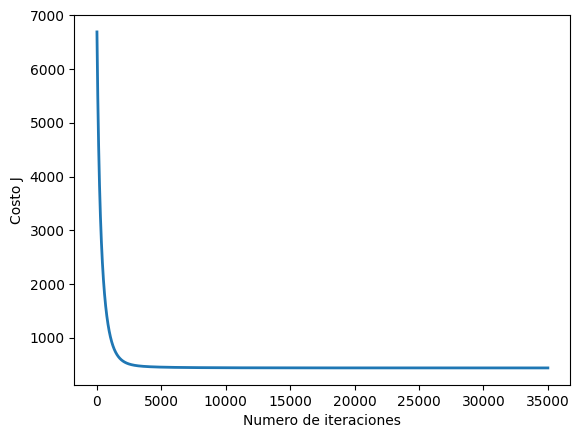

In [56]:
# Grafica la convergencia del costo
pyplot.plot(np.arange(len(J_historico)), J_historico, lw=2)
pyplot.xlabel('Numero de iteraciones')
pyplot.ylabel('Costo J')

[[ 1.         -1.15456823 -0.15173668 ... -1.59780375 -0.07368526
   2.23745711]
 [ 1.         -1.15456823 -0.19417952 ... -1.55394749 -0.07368526
   2.4868335 ]
 [ 1.         -1.16557485 -0.32150801 ... -1.55394749 -0.07368526
   3.23496265]
 ...
 [ 1.         -0.83537634 -0.53372217 ... -1.19578807 -0.07368526
  -0.50568311]
 [ 1.         -0.9344359  -0.53372217 ... -1.16655056 -0.07368526
  -0.42255765]
 [ 1.         -0.90141605 -0.53372217 ... -1.38583184 -0.07368526
  -0.33943218]]


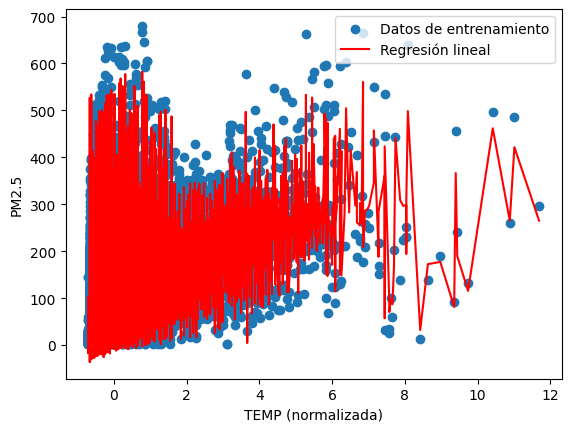

In [71]:
print(X_ready)
def graficarRegresion(x, y, X, theta, xlabel, ylabel):
    fig = pyplot.figure()
    pyplot.scatter(x, y, label='Datos de entrenamiento')
    
    # Ordena los valores de x y X para la visualización de la línea de regresión
    sort_idx = np.argsort(x)
    x_sorted = x[sort_idx]
    X_sorted = X[sort_idx]
    
    # Calcula los valores de y para la línea de regresión
    y_pred = np.dot(X_sorted, theta)

    # Gráfica la línea de regresión
    pyplot.plot(x_sorted, y_pred, color='red', label='Regresión lineal')
    
    pyplot.xlabel(xlabel)
    pyplot.ylabel(ylabel)
    pyplot.legend()
    pyplot.show()

index_CO2 = 2

# Grafica la dispersión y la línea de regresión
graficarRegresion(X_ready[:, index_CO2], y, X_ready, theta, 'CO2 (normalizada)', 'PM2.5')



In [53]:
#Utilizando la ecuacion de la normal

def calcularThetaEcuacionNormal(X, y):
    # Agregar una columna de unos para el término de intercepción si aún no está presente
    if X.shape[1] == len(features_columns):  # features_columns es la lista de características
        X = np.concatenate([np.ones((m, 1)), X], axis=1)
    
    # Calcular theta utilizando la ecuación normal
    theta = np.dot(np.linalg.inv(np.dot(X.T, X)), np.dot(X.T, y))
    return theta


In [54]:
theta_normal = calcularThetaEcuacionNormal(X_norm, y)
print(f"Los valores de theta calculados con la Ecuación Normal son: {theta_normal}")


Los valores de theta calculados con la Ecuación Normal son: [ 82.93337204  51.73247215   2.18133983   5.9215034   19.80872779
   6.86162585 -12.54963876   6.04679135  19.77193282   0.15121217
  -0.15238176]
